<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/nursery_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 保育所
- input:
    - [（認可）保育所](https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000099/resource/f3a1b2c5-a037-4627-9166-2a4863bf3bd9)
    - [児童館](https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000099/resource/ef6db4bc-966b-48cd-88ac-5922d413ad0b)
- output:
    - nursery_score.csv
        - 保育園スコア
        - 児童館スコア

In [1]:
!pip install -q japanize-matplotlib

     |████████████████████████████████| 4.1 MB 5.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
output_master_file = 'nursery_master.csv'
output_score_file = 'nursery_score.csv'

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

### 保育所

In [7]:
nursery_url = 'https://www.opendata.metro.tokyo.lg.jp/fukushihoken/R3/202110-2-1-hoikusyo.csv'
df_nursery = get_data_csv_url(nursery_url, encoding='shift-jis')
print(df_nursery.shape)

(3431, 9)


In [8]:
df_nursery['市区町村名'] = df_nursery['所在地'].str.extract('(^.*?[区市])', expand=False)
df_nursery['施設分類'] = '認可保育所'

df_nursery_master = df_nursery[
    (df_nursery['市区町村名'].notna())&
    (df_nursery['市区町村名'].str.endswith('区'))&
    (df_nursery['市区町村名'].str.len() < 5)
][['市区町村名', '施設分類', '設置', '施設名', '所在地', '緯度', '経度', '定員']].rename(columns={'施設名':'名称'}).reset_index(drop=True)
print(df_nursery_master.shape)

assert df_nursery_master['市区町村名'].nunique() == 23

(2526, 8)


### 児童館

In [9]:
childrenhouse_url = 'https://www.opendata.metro.tokyo.lg.jp/fukushihoken/R3/202110-2-2-06-zidoukan.csv'
df_childrenhouse = get_data_csv_url(childrenhouse_url, encoding='shift-jis')
print(df_childrenhouse.shape)

(587, 9)


In [10]:
df_childrenhouse['市区町村名'] = df_childrenhouse['所在地'].str.extract('(^.*?[区市])', expand=False)
df_childrenhouse['施設分類'] = '児童館'

df_childrenhouse_master = df_childrenhouse[
    (df_childrenhouse['市区町村名'].notna())&
    (df_childrenhouse['市区町村名'].str.endswith('区'))&
    (df_childrenhouse['市区町村名'].str.len() < 5)
][['市区町村名', '施設分類', '設置', '施設名', '所在地', '緯度', '経度']].rename(columns={'施設名':'名称'}).reset_index(drop=True)
print(df_childrenhouse_master.shape)

assert df_childrenhouse_master['市区町村名'].nunique() == 23

(439, 7)


### 保育所マスタ

In [11]:
df_nursery_master = pd.concat([df_nursery_master, df_childrenhouse_master]).reset_index(drop=True)
print(df_nursery_master.shape)

(2965, 8)


In [12]:
df_nursery_master.to_csv(os.path.join(DIR_NAME, output_master_file), index=False)

In [13]:
df_nursery_master

,市区町村名,施設分類,設置,名称,所在地,緯度,経度,定員
0,千代田区,認可保育所,営利法人,ほっぺるランド外神田,千代田区外神田４−８−６,35.70233,139.77260,87.0
1,千代田区,認可保育所,社福法人,外神田かなりや保育園,千代田区外神田３−６−１３,35.70255,139.76976,50.0
2,千代田区,認可保育所,区市町村,いずみこども園,千代田区神田和泉町１,35.69919,139.77597,36.0
3,千代田区,認可保育所,営利法人,あい保育園東神田,千代田区東神田２−６−５ 東神田ビル２・３階,35.69564,139.78027,63.0
4,千代田区,認可保育所,社福法人,岩本町ちとせ保育園,千代田区岩本町２−１０−１２,35.69344,139.77722,69.0
...,...,...,...,...,...,...,...,...
2960,江戸川区,児童館,区市町村,共育プラザ平井,江戸川区平井７−２１−６,35.71465,139.84042,NaN
2961,江戸川区,児童館,区市町村,共育プラザ小岩,江戸川区北小岩２−１４−１７,35.73995,139.88454,NaN
2962,江戸川区,児童館,区市町村,共育プラザ南小岩,江戸川区南小岩４−５−８,35.72095,139.88564,NaN
2963,江戸川区,児童館,区市町村,共育プラザ南篠崎,江戸川区南篠崎町３−１２−８,35.69662,139.89914,NaN


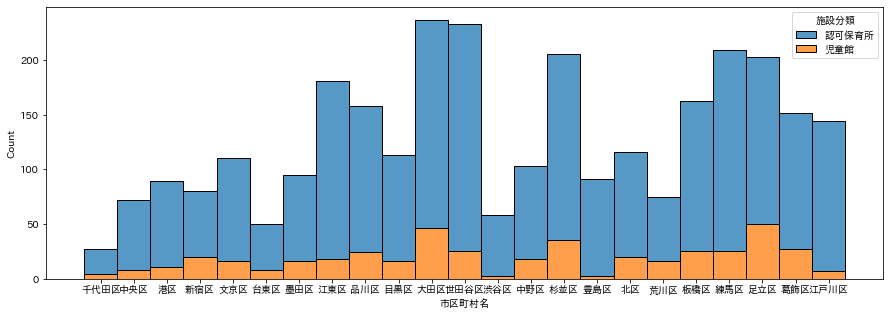

In [14]:
plt.figure(figsize=(15, 5))
sns.histplot(df_nursery_master, x='市区町村名', hue='施設分類', multiple='stack')
plt.show()

### 人口マスタ

In [15]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度', '0〜4歳（人）', '5〜9歳（人）']]
df_pop_master['子供人数'] = df_pop_master['0〜4歳（人）'] + df_pop_master['5〜9歳（人）']
print(df_pop_master.shape)

(3145, 9)


In [16]:
df_pop_master[1000:1010]

,地域ID,市区町村名,町名,町丁目,緯度,経度,0〜4歳（人）,5〜9歳（人）,子供人数
1000,109098,品川区,小山,小山７丁目,35.610531,139.697211,43,46,89
1001,109100,品川区,荏原,荏原１丁目,35.620000,139.713758,95,99,194
1002,109101,品川区,荏原,荏原２丁目,35.618353,139.710863,92,111,203
1003,109102,品川区,荏原,荏原３丁目,35.617980,139.707414,106,69,175
1004,109103,品川区,荏原,荏原４丁目,35.615629,139.706990,173,120,293
1005,109104,品川区,荏原,荏原５丁目,35.614516,139.703017,121,97,218
1006,109105,品川区,荏原,荏原６丁目,35.612208,139.704202,155,155,310
1007,109106,品川区,荏原,荏原７丁目,35.611072,139.700349,121,126,247
1008,109108,品川区,平塚,平塚１丁目,35.614842,139.715565,118,82,200
1009,109109,品川区,平塚,平塚２丁目,35.616792,139.713765,151,113,264


In [17]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'min_param':
            # 最小の距離の時の他のパラメータを返す
            min_idx = dist.idxmin()
            if np.isnan(min_idx):
                val = np.NaN
            else:
                val = _df_cat.iloc[min_idx][param]
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [18]:
import numpy as np
from scipy.stats import norm

def rank_score(sr_data):
    count = len(sr_data)
    rank = sr_data.rank()
    x = (rank + 1)/(count + 1)
    max_val = 5
    y = norm.ppf(x, loc=0.5, scale=0.14)*max_val
    return np.clip(y, 0, max_val)

## 保育園スコア

In [19]:
%%time
# 一番近い施設の距離
df_pop_master['保育園(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'min')
# 1km以内の施設の数
df_pop_master['保育園(数)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'count', 1)
# 最寄りの保育園
df_pop_master['最寄りの保育園'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'min_param', '名称')
# 最寄りの保育園の定員
df_pop_master['保育園(定員)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '認可保育所', 'min_param', '定員')

# 一番近い施設の距離
df_pop_master['児童館(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '児童館', 'min')
# 2km以内の施設の数
df_pop_master['児童館(数)'] = get_value_of_nearest_facility(df_pop_master, df_nursery_master, '児童館', 'count', 2)

CPU times: user 14min 37s, sys: 3.28 s, total: 14min 40s
Wall time: 14min 49s


In [20]:
df_pop_master['保育園(定員割合)'] = df_pop_master['保育園(定員)'] / df_pop_master['子供人数']
df_pop_master['保育園(定員割合)'] = df_pop_master['保育園(定員割合)'].replace(np.inf, np.nan).fillna(0)

In [21]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 16)


,地域ID,市区町村名,町名,町丁目,緯度,経度,0〜4歳（人）,5〜9歳（人）,子供人数,保育園(最近傍距離),保育園(数),最寄りの保育園,保育園(定員),児童館(最近傍距離),児童館(数),保育園(定員割合)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,0,0,0,0.747610,3,ＥＤＯ日本橋保育園,60.0,1.223562,4,0.0
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,0,0,0,0.841154,1,まなびの森保育園銀座,93.0,1.588228,3,0.0
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,0,0,0,0.611528,1,まなびの森保育園銀座,93.0,1.570712,4,0.0
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0,0,0,0.324671,3,ベネッセ内神田保育園,60.0,1.352763,5,0.0
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0,0,0,0.306243,4,ベネッセ内神田保育園,60.0,0.973485,5,0.0


### 保育園スコア

In [22]:
all_feature_list = []
all_score_list = []

In [23]:
score_name = '保育園スコア'
feature_list = {
    '保育園(最近傍距離)':   {'sort': -1, 'weight': 1}, 
    '保育園(数)':           {'sort': 1, 'weight': 0.5},
    '保育園(定員割合)':     {'sort': 1, 'weight': 0.8}, 
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

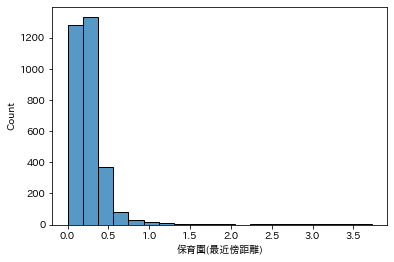

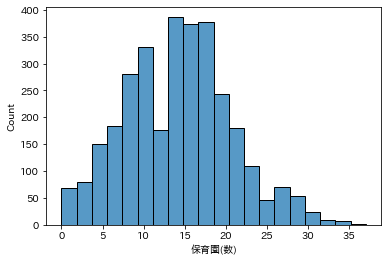

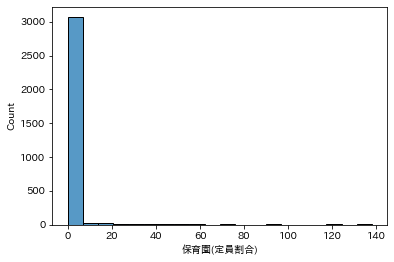

In [24]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [25]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

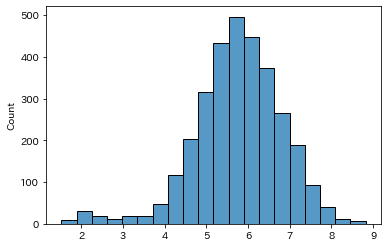

In [26]:
sns.histplot(_tmp_score, bins=20)
plt.show()

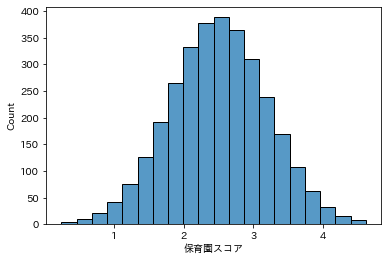

In [27]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [28]:
df_pop_master[score_name].describe()

count    3141.000000
mean        2.498590
std         0.694125
min         0.244358
25%         2.028207
50%         2.499442
75%         2.970394
max         4.612732
Name: 保育園スコア, dtype: float64

### 児童館スコア

In [29]:
score_name = '児童館スコア'
feature_list = {
    '児童館(最近傍距離)':       {'sort': -1, 'weight': 1}, 
    '児童館(数)':               {'sort': 1, 'weight': 0.5},
}
all_feature_list += list(feature_list.keys())
all_score_list.append(score_name)

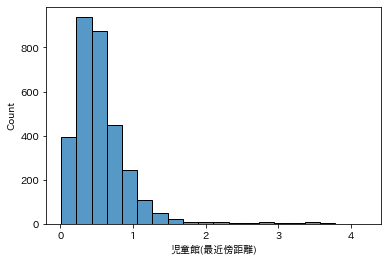

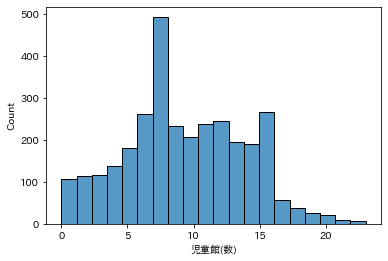

In [30]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [31]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

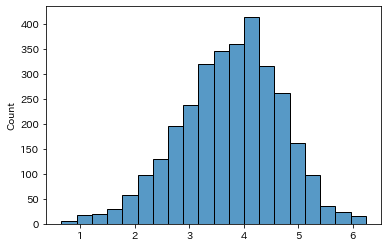

In [32]:
sns.histplot(_tmp_score, bins=20)
plt.show()

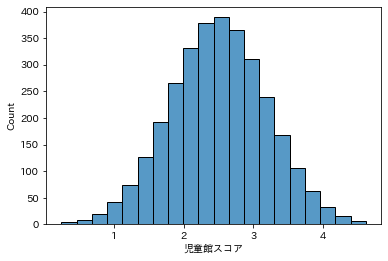

In [33]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [34]:
df_pop_master[score_name].describe()

count    3141.000000
mean        2.498590
std         0.694125
min         0.244358
25%         2.028207
50%         2.499442
75%         2.970394
max         4.612732
Name: 児童館スコア, dtype: float64

### 保存

In [35]:
all_feature_list

['保育園(最近傍距離)', '保育園(数)', '保育園(定員割合)', '児童館(最近傍距離)', '児童館(数)']

In [36]:
all_score_list

['保育園スコア', '児童館スコア']

In [37]:
df_pop_master['保育園(最近傍距離)'] = df_pop_master['保育園(最近傍距離)'].round(3)
df_pop_master['児童館(最近傍距離)'] = df_pop_master['児童館(最近傍距離)'].round(3)
df_pop_master['保育園(定員割合)'] = df_pop_master['保育園(定員割合)'].round(3)
for col in all_score_list:
    df_pop_master[col] = df_pop_master[col].round(3)

In [38]:
df_pop_master[
    ['地域ID'] + all_feature_list + ['最寄りの保育園'] + all_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

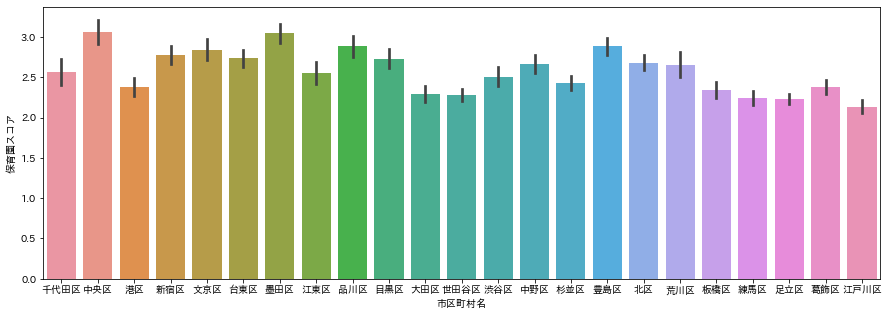

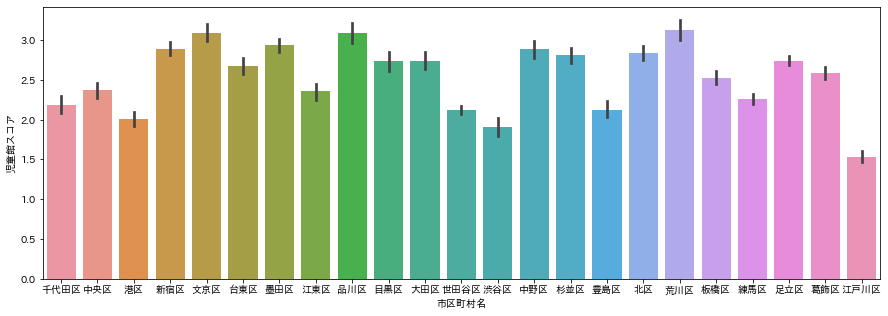

In [39]:
for _score in all_score_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=_score, data=df_pop_master)
    plt.show()

In [40]:
def get_score_top(df_data, target, ):
    df_level = df_data.copy()
    score_name = f'{target}スコア'
    feature_cols = [col for col in all_feature_list if col.startswith(target)]
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目'] + feature_cols + [score_name]
    ].reset_index(drop=True)
    return df_level

In [41]:
df_level = get_score_top(df_pop_master, '保育園')
print(df_level.shape)
df_level.head(10)

(910, 7)


,市区町村名,町名,町丁目,保育園(最近傍距離),保育園(数),保育園(定員割合),保育園スコア
0,墨田区,両国,両国１丁目,0.021,27,1.458,4.613
1,新宿区,市谷長延寺町,市谷長延寺町,0.060,16,74.000,4.565
2,千代田区,岩本町,岩本町２丁目,0.015,24,0.958,4.525
3,江東区,森下,森下３丁目,0.011,34,0.369,4.491
4,千代田区,東神田,東神田２丁目,0.063,29,4.846,4.461
5,品川区,東中延,東中延２丁目,0.038,31,0.923,4.434
6,練馬区,関町東,関町東２丁目,0.022,15,2.148,4.410
7,墨田区,錦糸,錦糸３丁目,0.033,20,1.532,4.388
8,墨田区,緑,緑３丁目,0.035,31,0.533,4.368
9,中央区,日本橋人形町,日本橋人形町３丁目,0.040,27,0.882,4.349


In [42]:
df_level.tail(10)

,市区町村名,町名,町丁目,保育園(最近傍距離),保育園(数),保育園(定員割合),保育園スコア
900,千代田区,千代田,千代田,0.985,1,0.0,0.949
901,千代田区,霞が関,霞が関３丁目,1.002,0,0.0,0.942
902,大田区,京浜島,京浜島１丁目,1.094,0,0.0,0.907
903,品川区,東八潮,東八潮,1.098,0,0.0,0.900
904,大田区,東海,東海１丁目,1.199,0,0.0,0.884
905,千代田区,日比谷公園,日比谷公園,1.260,0,0.0,0.876
906,千代田区,皇居外苑,皇居外苑,1.284,0,0.0,0.859
907,江東区,新木場,新木場１丁目,1.706,0,0.0,0.791
908,大田区,城南島,城南島１丁目,2.419,0,0.0,0.669
909,江東区,若洲,若洲１丁目,2.981,0,0.0,0.566


In [43]:
df_level = get_score_top(df_pop_master, '児童館')
print(df_level.shape)
df_level.head(10)

(910, 6)


,市区町村名,町名,町丁目,児童館(最近傍距離),児童館(数),児童館スコア
0,大田区,大森東,大森東１丁目,0.016,15,4.613
1,杉並区,上荻,上荻１丁目,0.031,16,4.565
2,品川区,東中延,東中延２丁目,0.038,18,4.525
3,新宿区,東五軒町,東五軒町,0.029,15,4.491
4,文京区,本駒込,本駒込３丁目,0.034,16,4.461
5,品川区,西大井,西大井６丁目,0.101,22,4.434
6,品川区,西中延,西中延３丁目,0.048,18,4.410
7,目黒区,目黒,目黒２丁目,0.033,15,4.388
8,大田区,中央,中央１丁目,0.074,20,4.368
9,品川区,豊町,豊町４丁目,0.086,21,4.349


In [44]:
df_level.tail(10)

,市区町村名,町名,町丁目,児童館(最近傍距離),児童館(数),児童館スコア
900,世田谷区,玉堤,玉堤２丁目,1.454,1,1.085
901,江戸川区,東葛西,東葛西２丁目,1.472,1,1.081
902,千代田区,皇居外苑,皇居外苑,1.807,2,1.067
903,江戸川区,東篠崎町,東篠崎町,1.559,1,1.053
904,江東区,新木場,新木場１丁目,1.806,1,1.008
905,江戸川区,南葛西,南葛西１丁目,2.279,0,0.922
906,江戸川区,臨海町,臨海町２丁目,2.524,0,0.868
907,大田区,城南島,城南島１丁目,2.784,0,0.802
908,江東区,若洲,若洲１丁目,2.946,0,0.756
909,江戸川区,堀江町,堀江町,3.622,0,0.475
